# E-Flux2 (08302023 data + StrainDesign) 
The purpose of the notebook is to run flux balance analysis to find the set of genome scale fluxes that maximizes biomass production.<br><br>
The flux balance analysis results are then compared to reaction rates determined by 13C-metabolic flux analysis (13C-MFA). <br><br>
The results of this notebook will be compared to transcript constained genome scale model flux results via E-Flux2. <br><br>
This notebook looks at glucose, glycerol, acetate, and oleic acid as sole carbon sources. <br><br>
In all cases, parsimonious flux balance analysis (pFBA) was used to prevent degenerate solutions.


### Load imports

In [1]:
import cobra
import pandas as pd
import sys

source_dir = '../src'
sys.path.append(source_dir)

from get_gene_transcript_dictionary import get_gene_transcript_dictionary
from get_reaction_transcript_dictionary import get_reaction_transcript_dictionary

from get_pfba_biomass_flux import get_pfba_biomass_flux
from get_eflux2_biomass_fluxes import get_eflux2_biomass_fluxes
from get_eflux2_fva_fluxes import get_eflux2_fva_fluxes

from add_flux_column_to_13c_flux_df import add_flux_column_to_13c_flux_df
from add_fva_columns_to_13c_flux_df import add_fva_columns_to_13c_flux_df
from add_transcript_values_to_13c_flux_df import add_transcript_values_to_13c_flux_df

from make_4_boxplot_grid import make_4_boxplot_grid


### Load the genome scale model

In [2]:
model = cobra.io.json.load_json_model('../genome_scale_models/iYLI647_corr_3.json')

### Rename some reactions to remove parentheses
This is because parentheses in reaction ids cause problems with StrainDesign

In [3]:
model.reactions.get_by_id('EX_glc(e)').id  = 'EX_glc_e'
model.reactions.get_by_id('EX_glyc(e)').id = 'EX_glyc_e'
model.reactions.get_by_id('EX_ocdcea(e)').id = 'EX_ocdcea_e'
model.reactions.get_by_id('EX_h2o(e)').id = 'EX_h2o_e'
model.reactions.get_by_id('EX_h(e)').id = 'EX_h_e'
model.reactions.get_by_id('EX_nh4(e)').id = 'EX_nh4_e'
model.reactions.get_by_id('EX_o2(e)').id = 'EX_o2_e'
model.reactions.get_by_id('EX_pi(e)').id = 'EX_pi_e'
model.reactions.get_by_id('EX_so4(e)').id = 'EX_so4_e'

# print an example reaction
model.reactions.get_by_id('EX_glc_e')

Reaction identifier,EX_glc_e
Name,D Glucose exchange
Memory address,0x15d991600
Stoichiometry,glc_D[e] <=> D_Glucose <=>
GPR,YALI0D01111g or YALI0D18876g or YALI0D00132g or YALI0B01342g or YALI0E23287g or YALI0B00396g or...
Lower bound,-10.0
Upper bound,1000.0


### Load transcriptomics data

In [4]:
transcriptomics_df = pd.read_csv("../data/transcriptomics/fpkm_counts.csv")
transcriptomics_df

,JGI_id,YALI0_id,glucose_1,glucose_2,glucose_3,glycerol_1,glycerol_2,glycerol_3,oleic_acid_1,oleic_acid_2,oleic_acid_3
0,jgi.p|Yarli1|64471,YALI0A00110g,4.88,2.64,3.23,1.21,1.11,3.61,6.77,13.32,7.67
1,jgi.p|Yarli1|64472,YALI0A00132g,1896.43,1845.77,1682.56,1234.99,1189.24,1120.35,864.64,1056.63,928.51
2,jgi.p|Yarli1|64473,YALI0A00154g,31.34,29.21,21.92,215.23,137.85,182.81,1867.59,2153.21,1958.68
3,jgi.p|Yarli1|64474,YALI0A00176g,3.67,3.85,3.15,3.07,1.74,2.09,4.13,2.43,4.34
4,jgi.p|Yarli1|64475,YALI0A00198g,0.00,0.17,0.00,0.00,0.50,1.29,1.55,0.81,1.75
...,...,...,...,...,...,...,...,...,...,...,...
6442,jgi.p|Yarli1|70913,YALI0F32043g,20.63,17.60,17.12,13.94,13.84,11.94,10.76,12.38,10.37
6443,jgi.p|Yarli1|70914,YALI0F32065g,192.58,151.54,270.76,206.89,262.66,280.82,310.55,384.22,313.24
6444,jgi.p|Yarli1|70915,YALI0F32131g,0.12,0.66,0.14,0.34,0.29,0.64,1.01,0.58,1.33
6445,jgi.p|Yarli1|70916,YALI0F32153g,26.16,27.73,28.77,39.22,36.95,39.18,26.98,22.05,23.58


### Make gene -> transcript dictionaries for each condition

In [5]:
glucose_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_1')
glucose_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_2')
glucose_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glucose_3')

glycerol_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_1')
glycerol_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_2')
glycerol_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'glycerol_3')

oleic_acid_1_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_1')
oleic_acid_2_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_2')
oleic_acid_3_gene_transcripts = get_gene_transcript_dictionary(transcriptomics_df, 'oleic_acid_3')

glycerol_1_gene_transcripts


{'': inf,
 'YALI0A00110g': 1.21,
 'YALI0A00132g': 1234.99,
 'YALI0A00154g': 215.23,
 'YALI0A00176g': 3.07,
 'YALI0A00198g': 0.0,
 'YALI0A00212g': 6.31,
 'YALI0A00264g': 431.05,
 'YALI0A00286g': 168.19,
 'YALI0A00330g': 36.85,
 'YALI0A00352g': 1262.91,
 'YALI0A00369g': 2.47,
 'YALI0A00374g': 1.58,
 'YALI0A00396g': 83.79,
 'YALI0A00418g': 6.61,
 'YALI0A00440g': 203.47,
 'YALI0A00506g': 45.01,
 'YALI0A00528g': 0.28,
 'YALI0A00550g': 4.35,
 'YALI0A00572g': 0.87,
 'YALI0A00594g': 465.39,
 'YALI0A00616g': 31.17,
 'YALI0A00638g': 55.68,
 'YALI0A00660g': 44.31,
 'YALI0A00682g': 0.45,
 'YALI0A00759g': 37.36,
 'YALI0A00781g': 50.04,
 'YALI0A00803g': 129.99,
 'YALI0A00825g': 13.48,
 'YALI0A00847g': 47.26,
 'YALI0A00869g': 1.04,
 'YALI0A00891g': 170.39,
 'YALI0A00913g': 57.17,
 'YALI0A00935g': 0.47,
 'YALI0A00957g': 14.66,
 'YALI0A00979g': 21.97,
 'YALI0A01001g': 70.77,
 'YALI0A01023g': 94.11,
 'YALI0A01045g': 86.39,
 'YALI0A01067g': 213.91,
 'YALI0A01089g': 35.88,
 'YALI0A01111g': 50.01,
 'YALI0A

### Make reaction -> transcript dictionaries for each condition

In [6]:
glucose_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_1_gene_transcripts)
glucose_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_2_gene_transcripts)
glucose_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glucose_3_gene_transcripts)

glycerol_1_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_1_gene_transcripts)
glycerol_2_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_2_gene_transcripts)
glycerol_3_reaction_transcripts = get_reaction_transcript_dictionary(model, glycerol_3_gene_transcripts)

oleic_acid_1_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_1_gene_transcripts)
oleic_acid_2_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_2_gene_transcripts)
oleic_acid_3_reaction_transcripts = get_reaction_transcript_dictionary(model, oleic_acid_3_gene_transcripts)

glycerol_1_reaction_transcripts

{'13BGH': 34.44,
 '13BGHe': 34.44,
 'ASADi': 370.66,
 '2DDA7Ptm': inf,
 '2DHPtm': inf,
 '2OHPH_5tn': inf,
 '2OMPH_5tm': inf,
 '2OMPH_5tn': inf,
 'ASPKi': 119.52,
 '34HPPOR': inf,
 '34HPPt2m': inf,
 '34HPPt2p': inf,
 '13GS': 0.39,
 '3C4MOPtm': inf,
 '3DSPHR': 107.06,
 '3HAO': 146.15,
 'GLCS2': 414.87,
 'SBTD_D2': 120.96,
 '3OPHB_5tm': inf,
 '4ABUTNtm': inf,
 '4ABUTtm': inf,
 '4ABZtm': inf,
 '4H2OGLTtm': inf,
 '4H2OGLTtp': inf,
 '4HBZtm': inf,
 '4HPRO_LTtm': inf,
 '4HTHRS': 185.27,
 '5AOPt2': 4.85,
 '5AOPtm': inf,
 '5MTHFtm': inf,
 '6PGLter': inf,
 '8AONNt2': inf,
 'AABTN': inf,
 'AASAD1': 172.08,
 'TRE6PP': 62.900000000000006,
 'ABTA': 88.19,
 'ABTt': inf,
 'ABUTDm': 0.4,
 'ABUTt2': 30.14,
 'TRE6PS': 23.91,
 'ACACT1m': 123.59,
 'ACACT4p': 581.47,
 'ACACT5p': 581.47,
 'ACACT6p': 581.47,
 'ACACT7p': 581.47,
 'ACACT8p': 581.47,
 'ACACT9p': 581.47,
 'PC': 535.91,
 'ACGAM6PS': 246.5,
 'ACGAMPM': 58.53,
 'ACGKm': 198.65,
 'ACGSm': 45.92,
 'ACOTAim': 212.89,
 'AGPRim': 198.65,
 'ACOAH': 488.85

### Load 13C-MFA and pFBA data

In [7]:
# load glucose 13C MFA data from ../data/13c_mfa/INCA_model_08302023_GR.xlsx
central_rxn_df = pd.read_excel('../data/13c_mfa/INCA_model_08302023_GR.xlsx', sheet_name='GSM Format')

# calculate the number of reactions in the 13C MFA that are mapped to the GSM
mapped_rxn_df = central_rxn_df.dropna(subset = ["reaction_ids"])

print(f'There are {len(mapped_rxn_df)} reactions in the 13C MFA that are mapped to the GSM')

central_rxn_df.head()

There are 43 reactions in the 13C MFA that are mapped to the GSM


,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_flux,glycerol_std_err,glycerol_LB,glycerol_UB,glycerol_ΔB,oleic_acid_flux,oleic_acid_std_err,oleic_acid_LB,oleic_acid_UB,oleic_acid_ΔB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.0000,23879.0,100.0000,100.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,100.00,4.911800e-10,100.0000,100.0000,0.0000,NaN,NaN,NaN,NaN,NaN
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,100.0000,2.201100e-11,100.0000,100.0000,0.0000
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.8093,4252.8,13.4786,21.3566,...,-12.29,5.856500e+00,-23.5032,-2.2969,21.2063,-151.6655,1.094870e+01,-165.8804,-1.3939,164.4865


# Glucose

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [8]:
glucose_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='glucose'
)
print(f'glucose max pfba biomass flux: {glucose_pfba_biomass_flux} g biomass per 100 mmols glucose')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='glucose',
    reaction_transcript_dictionary_list=[
        glucose_1_reaction_transcripts, 
        glucose_2_reaction_transcripts, 
        glucose_3_reaction_transcripts
    ]
)

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'glucose minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols glucose')

fva_biomass_cutoff = 0.99 * minimum_eflux2_biomass_flux

print(f'glucose FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols glucose')

glucose max pfba biomass flux: 9.845582347527 g biomass per 100 mmols glucose
glucose minimum eflux2 biomass flux: 7.995132464353654 g biomass per 100 mmols glucose
glucose FVA biomass cutoff flux: 7.915181139710118 g biomass per 100 mmols glucose


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [9]:
glucose_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='glucose',
    reaction_transcript_dictionary_list=[
        glucose_1_reaction_transcripts, 
        glucose_2_reaction_transcripts, 
        glucose_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
glucose_gsm_df.to_csv('../results/gsm_fluxes/glucose_gsm_fluxes.csv', index=False)

glucose_gsm_df.head()

Running pFBA FVA with the constraints: EX_glc_e = -100, biomass_glucose >= 7.915181139710118:
Running glucose E-Flux2 FVA with the constraints: EX_glc_e = -11.537123403818, biomass_glucose >= 0.9131842157240844:
Running glucose E-Flux2 FVA with the constraints: EX_glc_e = -6.977427399736, biomass_glucose >= 0.55227601758087:
Running glucose E-Flux2 FVA with the constraints: EX_glc_e = -7.071660612074, biomass_glucose >= 0.5597347470311903:


,reaction_id,reaction_name,full_reaction,glucose_pfba_flux,glucose_pfba_LB,glucose_pfba_UB,glucose_1_eflux2_flux,glucose_1_trans_LB,glucose_1_trans_UB,glucose_1_eflux2_LB,...,glucose_2_eflux2_flux,glucose_2_trans_LB,glucose_2_trans_UB,glucose_2_eflux2_LB,glucose_2_eflux2_UB,glucose_3_eflux2_flux,glucose_3_trans_LB,glucose_3_trans_UB,glucose_3_eflux2_LB,glucose_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-542.558865,-1000.000000,-182.367472,-606.412165,-inf,inf,-2678.025975,...,-612.516933,-inf,inf,-4060.379155,-444.256106,-611.897623,-inf,inf,-3827.921541,-439.150238
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-325.018420,-475.756773,-241.338827,-298.691626,-inf,inf,-407.801785,...,-292.224228,-inf,inf,-423.169991,-287.575351,-293.509932,-inf,inf,-413.628786,-286.500906
421,EX_h2o_e,H2O exchange,h2o[e] <=>,325.018420,241.338827,475.756773,298.691626,-8.667672e+04,8.667672e+03,285.669379,...,292.224228,-1.433193e+05,1.433193e+04,287.575351,423.169991,293.509932,-1.414095e+05,1.414095e+04,286.500906,413.628786
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],315.568098,-296.592265,1000.000000,279.012358,-2.790124e+02,2.790124e+02,-114.682450,...,337.685599,-5.459032e+02,5.459032e+02,-102.838195,545.903208,337.449074,-4.940848e+02,4.940848e+02,-109.515099,494.084797
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],315.568098,184.522645,658.920270,340.938768,0.000000e+00,3.682642e+04,262.017417,...,337.685599,0.000000e+00,5.749684e+04,264.274760,588.805112,337.449074,0.000000e+00,5.824431e+04,259.625182,590.567037


### Create a glucose central reaction dataframe from genome-scale predictions

In [10]:
glucose_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
glucose_central_rxn_df = add_flux_column_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, 'glucose_pfba_flux')
glucose_central_rxn_df = add_fva_columns_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, 'glucose_pfba_LB', 'glucose_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['glucose_1', 'glucose_2', 'glucose_3']:
    # add glucose eflux2 data for the specific trial
    glucose_central_rxn_df = add_flux_column_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_eflux2_flux')
    glucose_central_rxn_df = add_fva_columns_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    glucose_central_rxn_df = add_transcript_values_to_13c_flux_df(glucose_central_rxn_df, glucose_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
glucose_gsm_df.to_csv('../results/central_fluxes/glucose_central_fluxes.csv', index=False)

glucose_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glucose_2_eflux2_flux,glucose_2_eflux2_LB,glucose_2_eflux2_UB,glucose_2_trans_LB,glucose_2_trans_UB,glucose_3_eflux2_flux,glucose_3_eflux2_LB,glucose_3_eflux2_UB,glucose_3_trans_LB,glucose_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.000000,2.387900e+04,100.0000,100.0000,...,100.0,100.0,100.0,-14331.929846,14331.929846,100.0,100.0,100.0,-14140.950123,14140.950123
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,-21.119054,-22.663842,0.0,-28933.586612,28933.586612,-20.417419,-22.844421,0.0,-39248.065656,39248.065656
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.809300,4.252800e+03,13.4786,21.3566,...,-39.978955,-118.266683,-9.807359,-11211.152122,11211.152122,-39.382284,-132.120124,-6.702692,-10894.046565,10894.046565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,R82,NADH -> NADPH,NaN,NaN,NaN,0.000001,7.796100e-12,0.0000,3.4234,...,,,,,,,,,,
69,NaN,R83,NADH -> 2*ATP,NaN,NaN,NaN,344.144700,8.218000e+04,334.5028,354.6820,...,,,,,,,,,,
70,NaN,R84,UQH2 -> ATP,NaN,NaN,NaN,24.521600,5.855600e+03,22.0621,27.2136,...,,,,,,,,,,
71,NaN,R85,FADH2 -> ATP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,


### Plot glucose MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

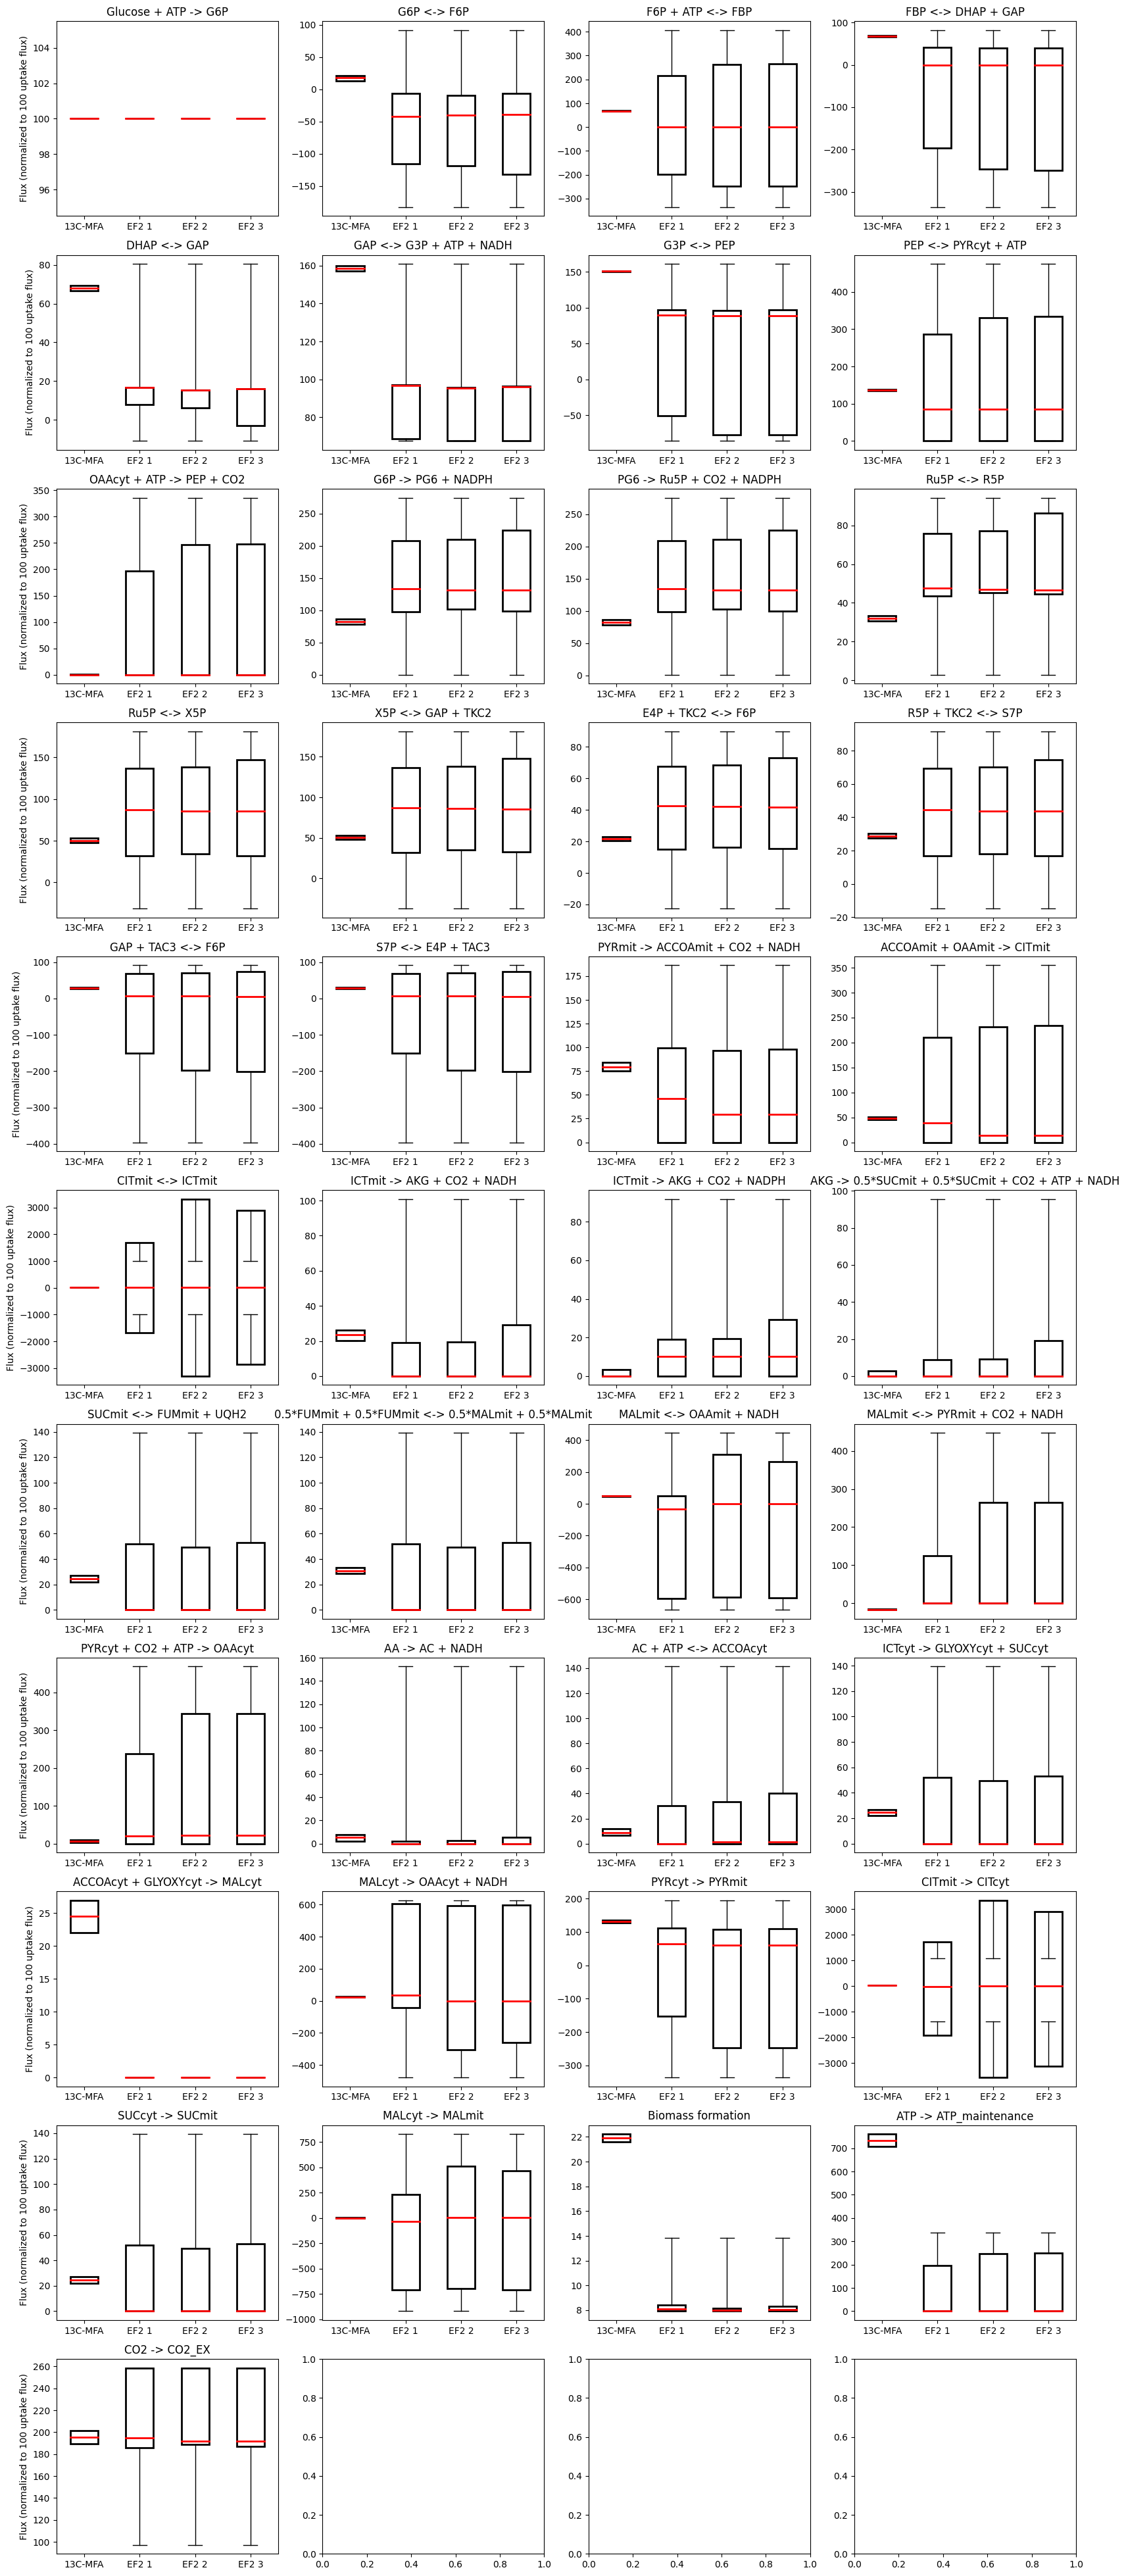

In [11]:
make_4_boxplot_grid(glucose_central_rxn_df, 'glucose')

# Glycerol

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [12]:
glycerol_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='glycerol'
)
print(f'glycerol max pfba biomass flux: {glycerol_pfba_biomass_flux} g biomass per 100 mmols glycerol')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='glycerol',
    reaction_transcript_dictionary_list=[
        glycerol_1_reaction_transcripts, 
        glycerol_2_reaction_transcripts, 
        glycerol_3_reaction_transcripts
    ]
)

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'glycerol minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols glycerol')

fva_biomass_cutoff = 0.99 * minimum_eflux2_biomass_flux

print(f'glycerol FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols glycerol')

glycerol max pfba biomass flux: 3.929714007262 g biomass per 100 mmols glycerol
glycerol minimum eflux2 biomass flux: 1.8179047929589003 g biomass per 100 mmols glycerol
glycerol FVA biomass cutoff flux: 1.7997257450293114 g biomass per 100 mmols glycerol


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [13]:
glycerol_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='glycerol',
    reaction_transcript_dictionary_list=[
        glycerol_1_reaction_transcripts, 
        glycerol_2_reaction_transcripts, 
        glycerol_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
glycerol_gsm_df.to_csv('../results/gsm_fluxes/glycerol_gsm_fluxes.csv', index=False)

glycerol_gsm_df.head()

Running pFBA FVA with the constraints: EX_glyc_e = -100, biomass_glucose >= 1.7997257450293114:
Running glycerol E-Flux2 FVA with the constraints: EX_glyc_e = -24.424089473317, biomass_glucose >= 0.43956662624028:
Running glycerol E-Flux2 FVA with the constraints: EX_glyc_e = -22.919345957193, biomass_glucose >= 0.412485369783937:
Running glycerol E-Flux2 FVA with the constraints: EX_glyc_e = -12.897831798751, biomass_glucose >= 0.23212559943269886:


,reaction_id,reaction_name,full_reaction,glycerol_pfba_flux,glycerol_pfba_LB,glycerol_pfba_UB,glycerol_1_eflux2_flux,glycerol_1_trans_LB,glycerol_1_trans_UB,glycerol_1_eflux2_LB,...,glycerol_2_eflux2_flux,glycerol_2_trans_LB,glycerol_2_trans_UB,glycerol_2_eflux2_LB,glycerol_2_eflux2_UB,glycerol_3_eflux2_flux,glycerol_3_trans_LB,glycerol_3_trans_UB,glycerol_3_eflux2_LB,glycerol_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-573.897862,-1000.000000,-174.442012,-426.335092,-inf,inf,-1314.829031,...,-429.542340,-inf,inf,-1344.884955,-410.719126,-409.071877,-inf,inf,-2120.460040,-298.302503
959,H2Ot,H2O transport via diffusion,h2o[e] <=> h2o[c],-359.991300,-535.468407,-206.735407,-221.579373,-inf,inf,-238.692899,...,-223.312063,-inf,inf,-238.692899,-217.971545,-249.172340,-inf,inf,-305.196662,-207.235664
421,EX_h2o_e,H2O exchange,h2o[e] <=>,359.991300,206.735407,535.468407,221.579373,-4.094318e+04,4094.318444,220.469554,...,223.312063,-4.363126e+04,4363.126251,217.971545,238.692899,249.172340,-7.753241e+04,7753.241131,207.235664,305.196662
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],315.493385,-164.645214,992.598648,216.302843,-2.163028e+02,216.302843,136.982089,...,223.158156,-2.469093e+02,246.909315,103.876147,246.909315,208.416110,-4.281340e+02,428.133975,-34.093544,428.133975
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,311.574259,114.143279,643.700702,249.790544,0.000000e+00,571.648741,244.593990,...,250.725400,0.000000e+00,688.850372,243.394473,277.928772,243.122643,0.000000e+00,1072.738443,188.802110,335.760165


### Create a glycerol central reaction dataframe from genome-scale predictions

In [14]:
glycerol_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
glycerol_central_rxn_df = add_flux_column_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, 'glycerol_pfba_flux')
glycerol_central_rxn_df = add_fva_columns_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, 'glycerol_pfba_LB', 'glycerol_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['glycerol_1', 'glycerol_2', 'glycerol_3']:
    # add glycerol eflux2 data for the specific trial
    glycerol_central_rxn_df = add_flux_column_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_eflux2_flux')
    glycerol_central_rxn_df = add_fva_columns_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    glycerol_central_rxn_df = add_transcript_values_to_13c_flux_df(glycerol_central_rxn_df, glycerol_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
glycerol_gsm_df.to_csv('../results/central_fluxes/glycerol_central_fluxes.csv', index=False)

glycerol_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,glycerol_2_eflux2_flux,glycerol_2_eflux2_LB,glycerol_2_eflux2_UB,glycerol_2_trans_LB,glycerol_2_trans_UB,glycerol_3_eflux2_flux,glycerol_3_eflux2_LB,glycerol_3_eflux2_UB,glycerol_3_trans_LB,glycerol_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.000000,2.387900e+04,100.0000,100.0000,...,0.0,0.0,0.0,-4363.126251,0.0,0.0,0.0,0.0,-7753.241131,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,100.0,0.0,0.0,-9820.131884,9820.131884,100.0,100.0,100.0,-20841.565016,20841.565016
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,inf,0.0,0.0,0.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.809300,4.252800e+03,13.4786,21.3566,...,-1.88993,-12.321804,-1.850664,-3888.854427,3888.854427,-2.178416,-38.288372,-1.850664,-6388.438095,6388.438095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,R82,NADH -> NADPH,NaN,NaN,NaN,0.000001,7.796100e-12,0.0000,3.4234,...,,,,,,,,,,
69,NaN,R83,NADH -> 2*ATP,NaN,NaN,NaN,344.144700,8.218000e+04,334.5028,354.6820,...,,,,,,,,,,
70,NaN,R84,UQH2 -> ATP,NaN,NaN,NaN,24.521600,5.855600e+03,22.0621,27.2136,...,,,,,,,,,,
71,NaN,R85,FADH2 -> ATP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,


### Plot glycerol MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

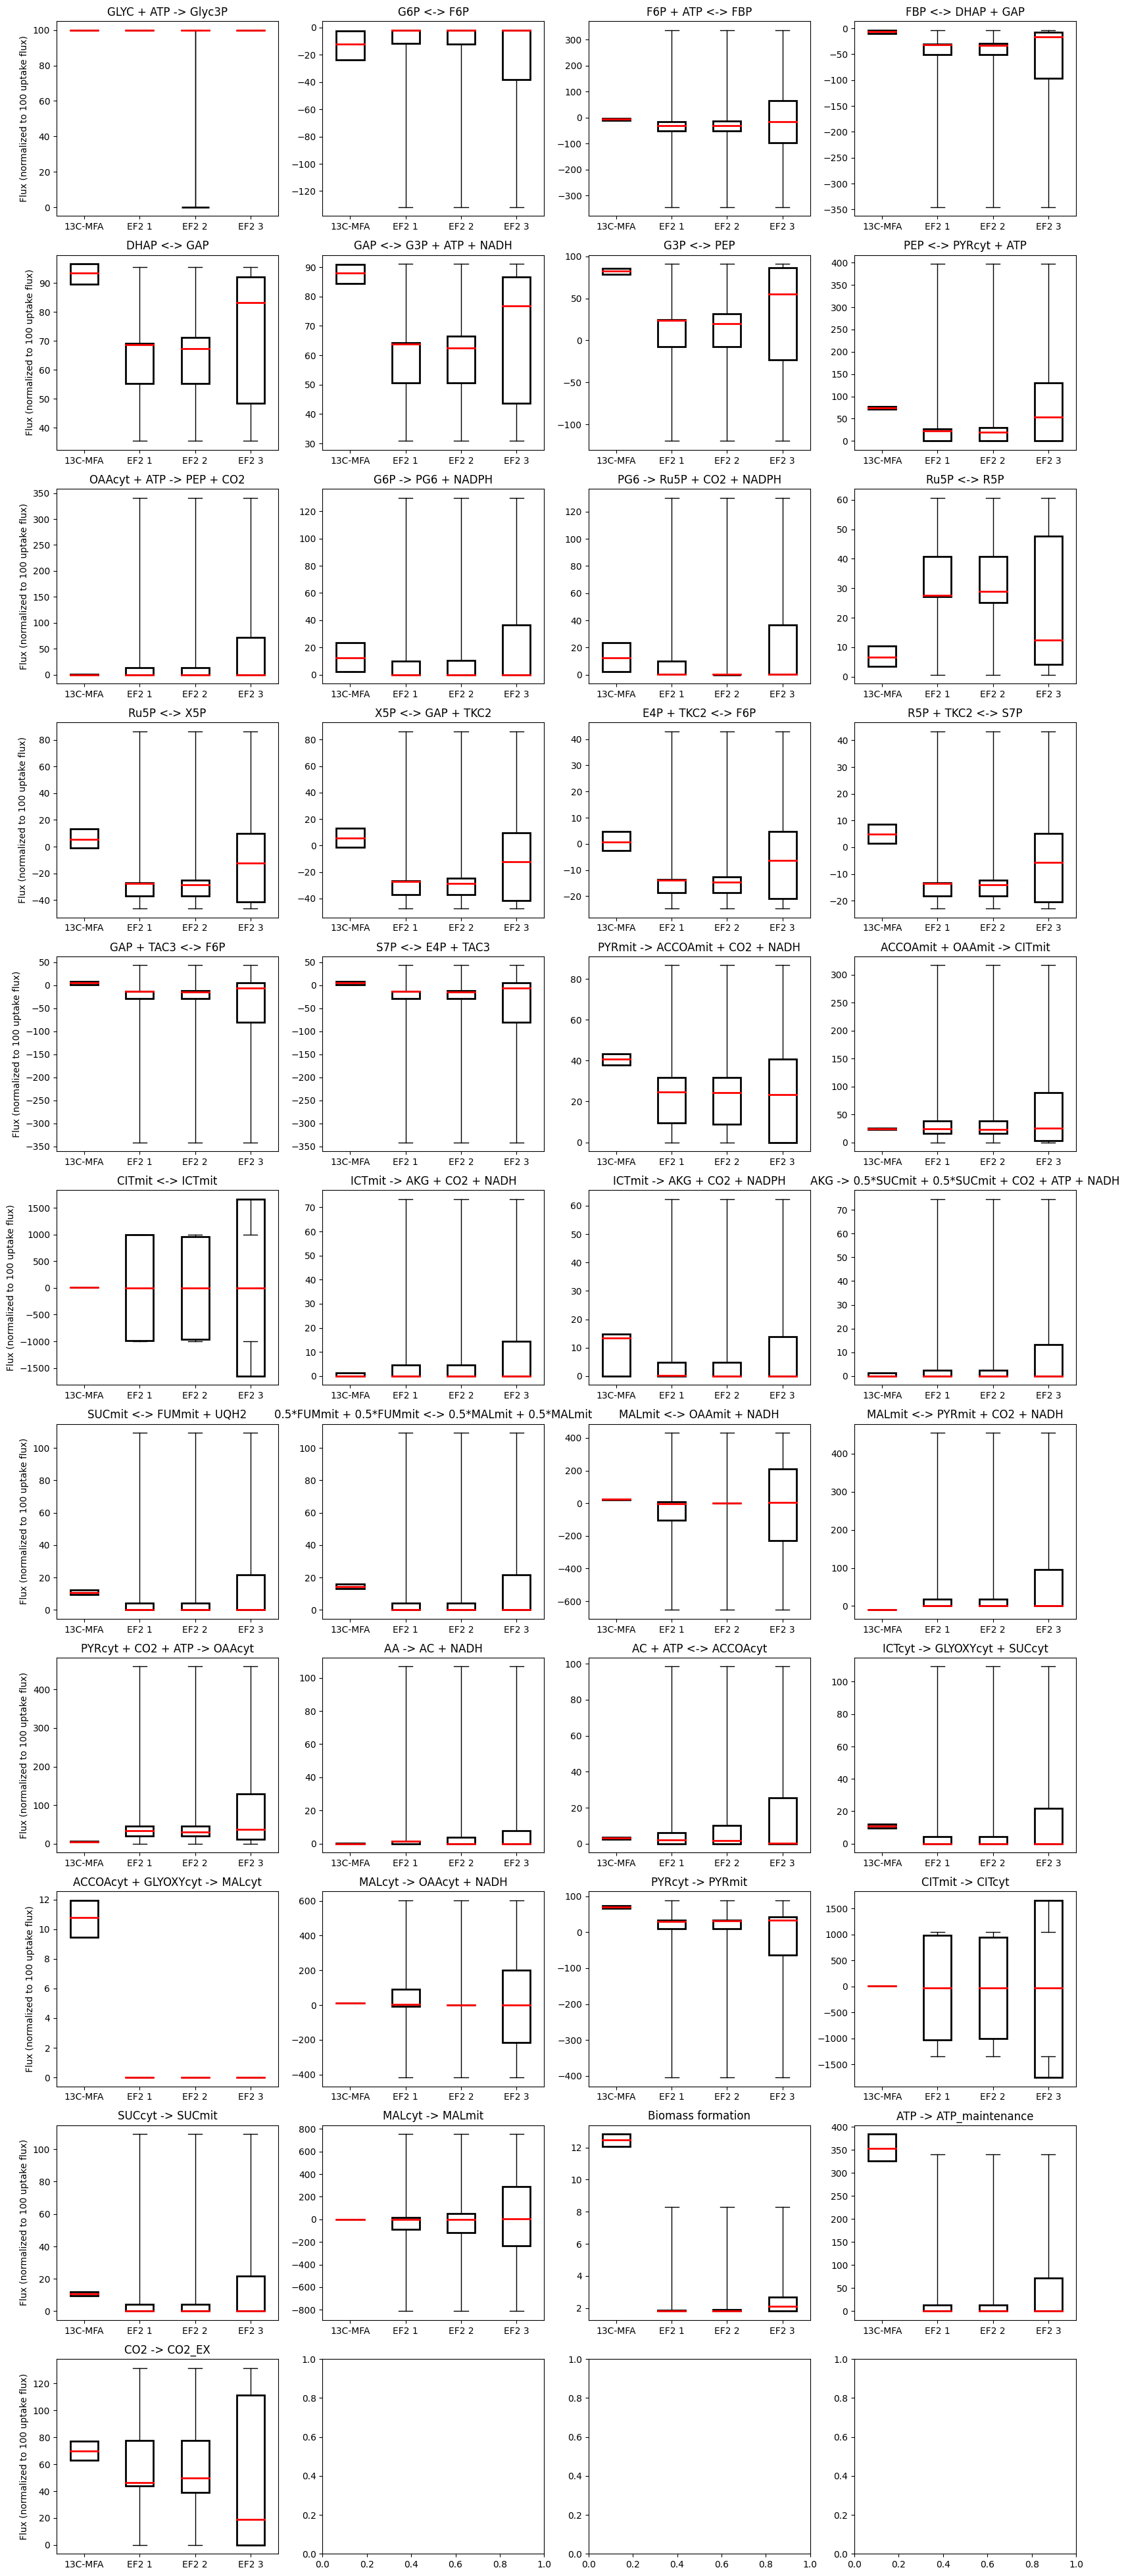

In [15]:
make_4_boxplot_grid(glycerol_central_rxn_df, 'glycerol')

# Oleic Acid

### Calculate the FVA biomass cutoff with quick pFBA and E-Flux2 test

In [16]:
oleic_acid_pfba_biomass_flux = get_pfba_biomass_flux(
  model=model, 
  substrate='oleic_acid'
)
print(f'oleic acid max pfba biomass flux: {oleic_acid_pfba_biomass_flux} g biomass per 100 mmols oleic acid')

eflux2_biomass_fluxes = get_eflux2_biomass_fluxes(
    model=model, 
    substrate='oleic_acid',
    reaction_transcript_dictionary_list=[
        oleic_acid_1_reaction_transcripts, 
        oleic_acid_2_reaction_transcripts, 
        oleic_acid_3_reaction_transcripts
    ]
)

minimum_eflux2_biomass_flux = min(eflux2_biomass_fluxes)
print(f'oleic acid minimum eflux2 biomass flux: {minimum_eflux2_biomass_flux} g biomass per 100 mmols oleic acid')

fva_biomass_cutoff = 0.99 * minimum_eflux2_biomass_flux

print(f'oleic acid FVA biomass cutoff flux: {fva_biomass_cutoff} g biomass per 100 mmols oleic acid')

oleic acid max pfba biomass flux: 24.000658871899997 g biomass per 100 mmols oleic acid
oleic acid minimum eflux2 biomass flux: 23.608019047825035 g biomass per 100 mmols oleic acid
oleic acid FVA biomass cutoff flux: 23.371938857346784 g biomass per 100 mmols oleic acid


### Create genome-scale dataframe with pFBA, E-Flux2, and bounds from FVA

In [17]:
oleic_acid_gsm_df = get_eflux2_fva_fluxes(
    model=model, 
    substrate='oleic_acid',
    reaction_transcript_dictionary_list=[
        oleic_acid_1_reaction_transcripts, 
        oleic_acid_2_reaction_transcripts, 
        oleic_acid_3_reaction_transcripts
    ],
    biomass_cutoff=fva_biomass_cutoff
)

# save as csv
oleic_acid_gsm_df.to_csv('../results/gsm_fluxes/oleic_acid_gsm_fluxes.csv', index=False)

oleic_acid_gsm_df.head()

Running pFBA FVA with the constraints: EX_ocdcea_e = -10, biomass_oleic_acid >= 2.3371938857346786:
Running oleic_acid E-Flux2 FVA with the constraints: EX_ocdcea_e = -2.463910118196, biomass_oleic_acid >= 0.57586356632475:
Running oleic_acid E-Flux2 FVA with the constraints: EX_ocdcea_e = -1.072993115995, biomass_oleic_acid >= 0.2507792950138914:
Running oleic_acid E-Flux2 FVA with the constraints: EX_ocdcea_e = -1.549878945322, biomass_oleic_acid >= 0.362236759463549:


,reaction_id,reaction_name,full_reaction,oleic_acid_pfba_flux,oleic_acid_pfba_LB,oleic_acid_pfba_UB,oleic_acid_1_eflux2_flux,oleic_acid_1_trans_LB,oleic_acid_1_trans_UB,oleic_acid_1_eflux2_LB,...,oleic_acid_2_eflux2_flux,oleic_acid_2_trans_LB,oleic_acid_2_trans_UB,oleic_acid_2_eflux2_LB,oleic_acid_2_eflux2_UB,oleic_acid_3_eflux2_flux,oleic_acid_3_trans_LB,oleic_acid_3_trans_UB,oleic_acid_3_eflux2_LB,oleic_acid_3_eflux2_UB
689,H2Otm,H2O transport mitochondrial,h2o[c] <=> h2o[m],-3253.249273,-10000.000000,-2735.236785,-2812.550833,-inf,inf,-8412.702321,...,-2812.550833,-inf,inf,-15917.425332,-2735.236785,-2812.550833,-inf,inf,-11950.377155,-2735.236785
607,ATPS3m,ATP synthase mitochondrial,adp[m] + 3.0 h[c] + pi[m] --> atp[m] + h2o[m] ...,2102.021653,2007.663281,2226.242666,2043.094223,0.000000e+00,4.890600e+03,2007.663281,...,2043.094223,0.000000e+00,1.038404e+04,2007.663281,2226.242666,2043.094223,0.000000e+00,6.585030e+03,2007.663281,2226.242666
976,PIt2m,phosphate transporter mitochondrial,h[c] + pi[c] <=> h[m] + pi[m],2100.101601,756.724324,3074.038832,2051.120950,-1.071386e+04,1.071386e+04,756.724324,...,2041.205582,-1.872519e+04,1.872519e+04,756.724324,3074.038832,2041.205582,-1.632837e+04,1.632837e+04,756.724324,3074.038832
990,ATPtm_H,ADPATP transporter mitochondrial,adp[c] + atp[m] + h[c] --> adp[m] + atp[c] + h[m],2100.101601,2002.334479,2387.824167,2041.205582,0.000000e+00,1.107471e+05,2002.334479,...,2041.205582,0.000000e+00,3.713500e+05,2002.334479,2387.824167,2041.205582,0.000000e+00,2.135289e+05,2002.334479,2387.824167
617,CYOR_u6m,ubiquinol 6 cytochrome c reductase,2.0 ficytc[m] + 1.5 h[m] + q6h2[m] --> 2.0 foc...,1934.708622,1854.338354,1999.290115,1975.039663,0.000000e+00,5.629670e+03,1854.338354,...,1975.039663,0.000000e+00,1.757420e+04,1854.338354,1999.290115,1975.039663,0.000000e+00,7.076037e+03,1854.338354,1999.290115


### Create a glycerol central reaction dataframe from genome-scale predictions

In [18]:
oleic_acid_central_rxn_df = central_rxn_df.copy()

# add pfba flux column
oleic_acid_central_rxn_df = add_flux_column_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_pfba_flux')
oleic_acid_central_rxn_df = add_fva_columns_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, 'oleic_acid_pfba_LB', 'oleic_acid_pfba_UB')

# loop over the three eflux2 fluxes and add them to the dataframe
for substrate_trial in ['oleic_acid_1', 'oleic_acid_2', 'oleic_acid_3']:
    # add oleic_acid eflux2 data for the specific trial
    oleic_acid_central_rxn_df = add_flux_column_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_eflux2_flux')
    oleic_acid_central_rxn_df = add_fva_columns_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_eflux2_LB', f'{substrate_trial}_eflux2_UB')
    oleic_acid_central_rxn_df = add_transcript_values_to_13c_flux_df(oleic_acid_central_rxn_df, oleic_acid_gsm_df, f'{substrate_trial}_trans_LB', f'{substrate_trial}_trans_UB')

# save as csv
oleic_acid_gsm_df.to_csv('../results/central_fluxes/oleic_acid_central_fluxes.csv', index=False)

oleic_acid_central_rxn_df

,Unnamed: 0,ID,Equation,reaction_ids,pathway,compartment,glucose_flux,glucose_std_err,glucose_LB,glucose_UB,...,oleic_acid_2_eflux2_flux,oleic_acid_2_eflux2_LB,oleic_acid_2_eflux2_UB,oleic_acid_2_trans_LB,oleic_acid_2_trans_UB,oleic_acid_3_eflux2_flux,oleic_acid_3_eflux2_LB,oleic_acid_3_eflux2_UB,oleic_acid_3_trans_LB,oleic_acid_3_trans_UB
0,uptake,uptake,Glucose + ATP -> G6P,reverse_EX_glc_e,substrate_uptake,cytosol,100.000000,2.387900e+04,100.0000,100.0000,...,0.0,0.0,0.0,-93197.242843,0.0,0.0,0.0,0.0,-64521.168122,0.0
1,uptake,R3 glyc3p,GLYC + ATP -> Glyc3P,reverse_GLYCt,emp,cytosol,NaN,NaN,NaN,NaN,...,0.0,-8.874546,0.0,-411748.214797,411748.214797,0.0,-8.874546,0.0,-236777.201928,236777.201928
2,uptake,R3 dhap net,Glyc3P <-> DHAP + UQH2,NaN,emp,cytosol,NaN,NaN,NaN,NaN,...,,,,,,,,,,
3,uptake,OA uptake,OA + ATP -> 9*ACCOAcyt + 7*NADH + 7*FADH2,OCDCEAt,substrate_uptake,cytosol,NaN,NaN,NaN,NaN,...,100.0,100.0,100.0,0.0,inf,100.0,100.0,100.0,0.0,inf
4,glycolysis/gluconeogensis,R4 net,G6P <-> F6P,PGI,emp,cytosol,17.809300,4.252800e+03,13.4786,21.3566,...,-30.926164,-226.300635,-30.616902,-77235.351061,77235.351061,-30.926164,-226.300635,-30.616902,-51781.463476,51781.463476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,NaN,R82,NADH -> NADPH,NaN,NaN,NaN,0.000001,7.796100e-12,0.0000,3.4234,...,,,,,,,,,,
69,NaN,R83,NADH -> 2*ATP,NaN,NaN,NaN,344.144700,8.218000e+04,334.5028,354.6820,...,,,,,,,,,,
70,NaN,R84,UQH2 -> ATP,NaN,NaN,NaN,24.521600,5.855600e+03,22.0621,27.2136,...,,,,,,,,,,
71,NaN,R85,FADH2 -> ATP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,,,,,,,,,


### Plot glycerol MFA vs E-Flux2 boxplots
pFBA lower and upper bounds are represented by whiskers

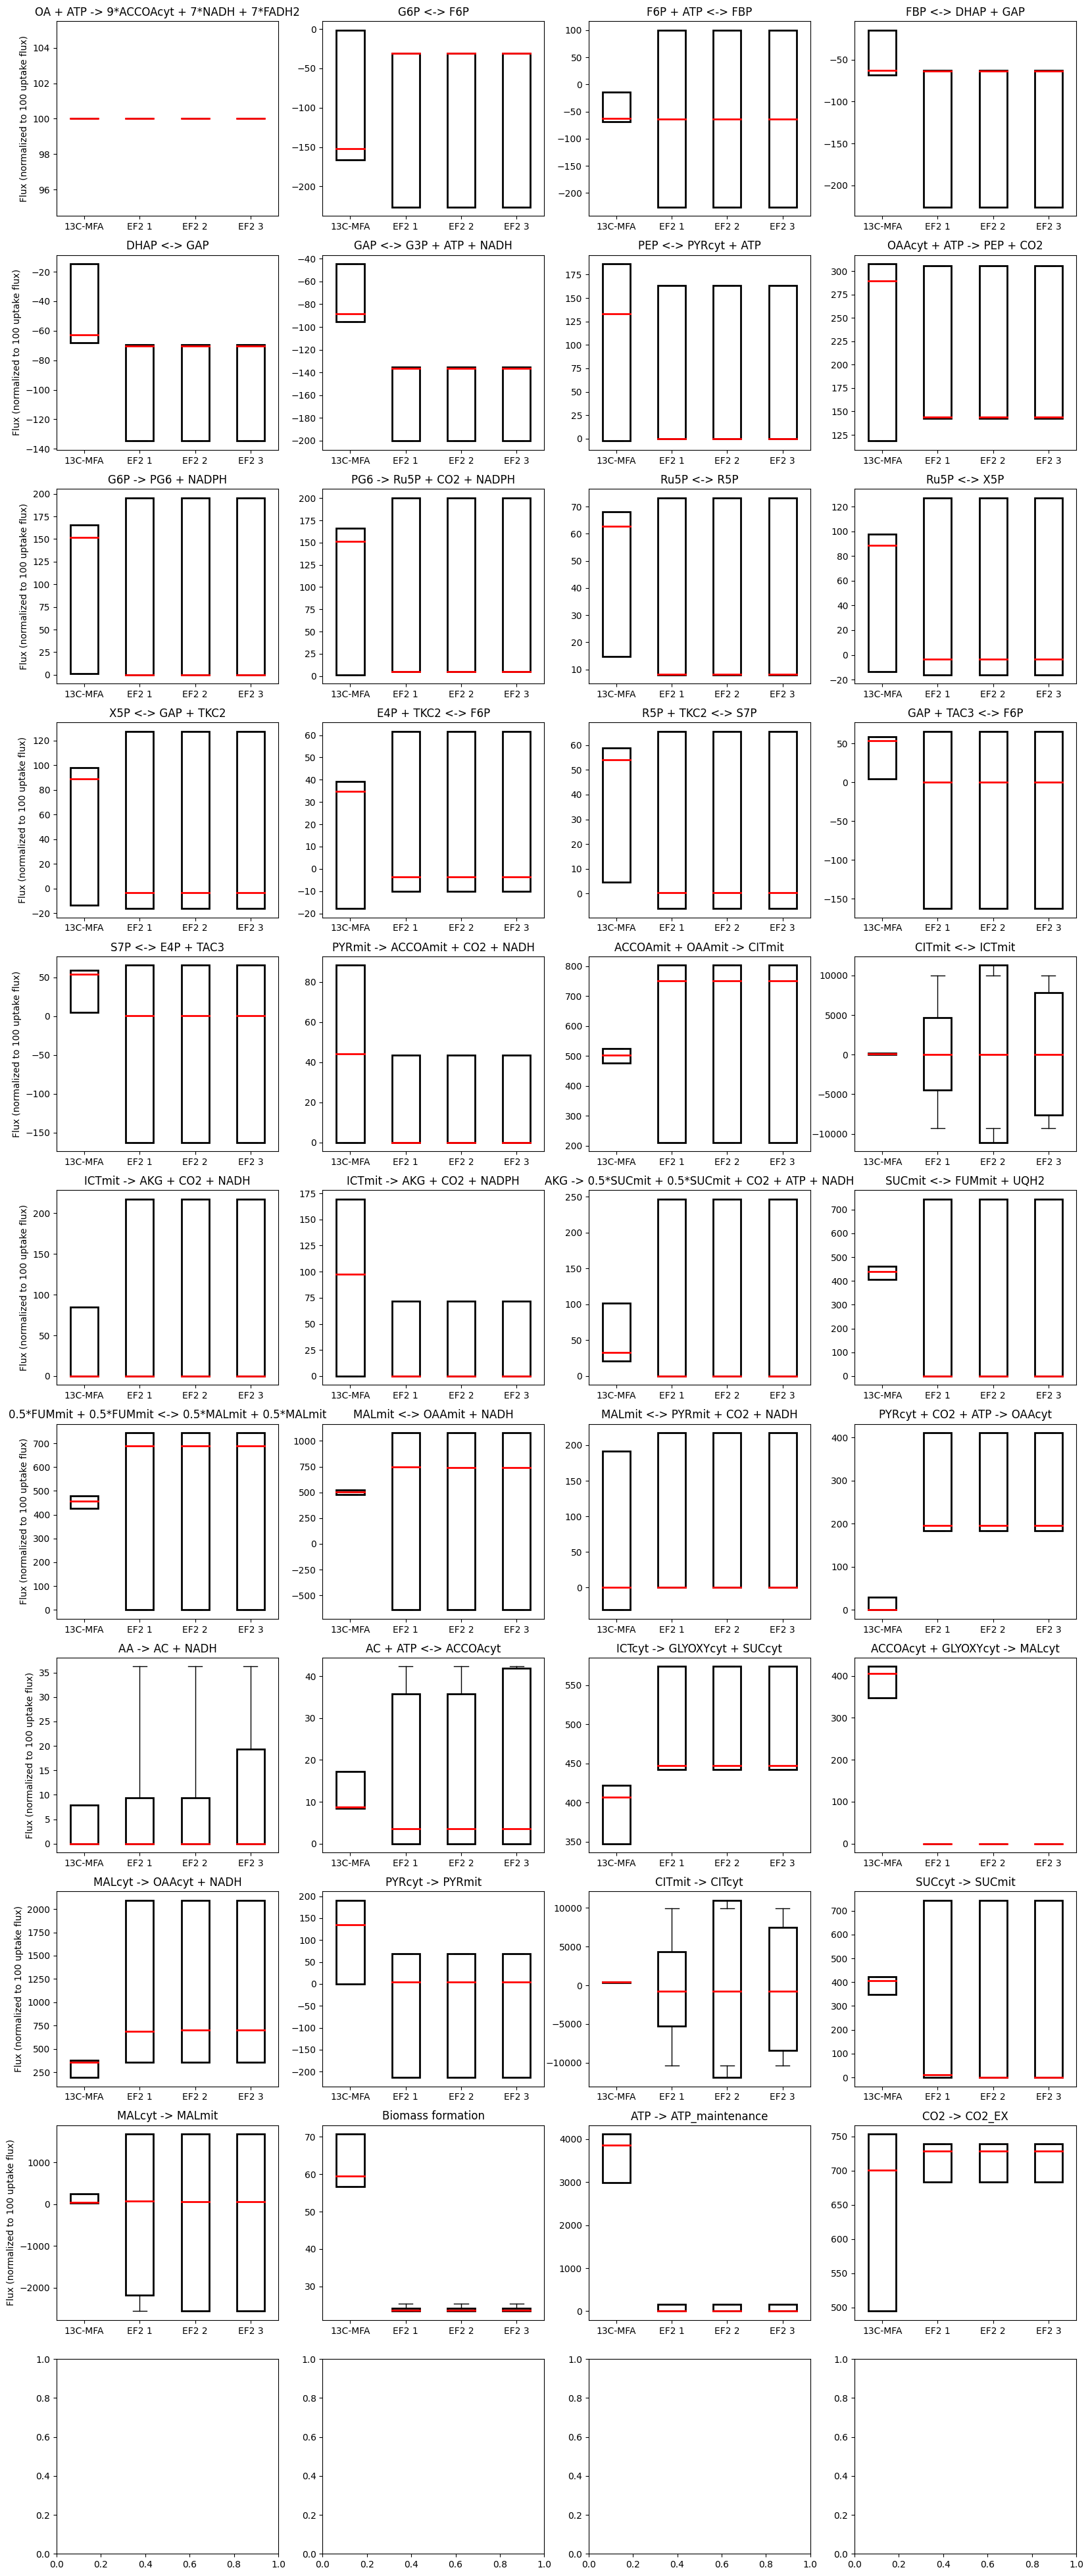

In [19]:
make_4_boxplot_grid(oleic_acid_central_rxn_df, 'oleic_acid')